## Milestones 2 P2

Name: Nadhifa Safira

Batch: HCK006

Problem Statement:

```Google aimed to develop a Google Translate-like system for identifying American Sign Language into written words.```

Objective:

To identify American Sign Language into written words using image classifier computer vision techniques.

Dataset: https://www.kaggle.com/datasets/grassknoted/asl-alphabet/

## Import Library

In [1]:
from google.colab import files
!pip install -q kaggle
uploaded = files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle
!ls -l ~/.kaggle
!cat ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle (5).json
kaggle.json
total 4
-rw------- 1 root root 64 Aug  4 23:24 kaggle.json
{"username":"dhifassi","key":"d45423411cb93a0ec83b11f5310b9a9b"}

In [2]:
!kaggle datasets download -d grassknoted/asl-alphabet

asl-alphabet.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
!unzip -q /content/asl-alphabet.zip

replace asl_alphabet_test/asl_alphabet_test/A_test.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [4]:
#Import Library
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

#For Modeling
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import utils
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.metrics import accuracy_score, classification_report
from keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras import optimizers,losses
from tensorflow.keras.optimizers import Adam


#For Train-Test Split
from sklearn.model_selection import train_test_split

## Data Loading & Overview

In [5]:
#Creating and creating train, validation data frame
def get_data(data_dir):
    datagen = ImageDataGenerator(
        rescale=1.0 / 255.0,
        validation_split=0.2,
    )

    train_gen = datagen.flow_from_directory(
        data_dir,
        target_size=(224,224),
        batch_size=32,
        class_mode='categorical',
        subset='training',
        shuffle=True
    )

    val_gen = datagen.flow_from_directory(
        data_dir,
        target_size=(224,224),
        batch_size=32,
        class_mode='categorical',
        subset='validation',
        shuffle=False,
    )

    return train_gen, val_gen

train_dir = '/content/asl_alphabet_train/asl_alphabet_train'
train_gen, val_gen = get_data(train_dir)


Found 69600 images belonging to 29 classes.
Found 17400 images belonging to 29 classes.


Based on the information provided, the dataset consists of 69,600 images distributed across 29 classes for the training set, 17,400 images distributed across 29 classes for the validation set.

In [6]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  seed=0,
  image_size=(224, 224),
  batch_size=34)

Found 87000 files belonging to 29 classes.


In train dataset, there are 87000 files/images in total and belongs to 29 classes.

In [7]:
#See the image size and shape
train_gen.next()[0].shape

(32, 224, 224, 3)

The `train_gen` generates batches containing 32 images, where each image has a height of 224 pixels, a width of 224 pixels, and three RGB color channels.

In [8]:
#to collect and read the data from data train and put it into two variables, images and labels
def get_data(data_dir) :
    images = []
    labels = []

    dir_list = os.listdir(data_dir)
    for i in range(len(dir_list)):
        print("Collecting images of", dir_list[i])
        for image in os.listdir(data_dir + "/" + dir_list[i]):
            img = cv2.imread(data_dir + '/' + dir_list[i] + '/' + image)
            images.append(img)
            labels.append(i)

    return images, labels

X, y = get_data(train_dir)

Image collected from each folder.

In [9]:
#Shows classes in the dataset
alphabets = train_dataset.class_names
alphabets

['A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'del',
 'nothing',
 'space']

## EDA/Visualization

<Figure size 640x480 with 0 Axes>

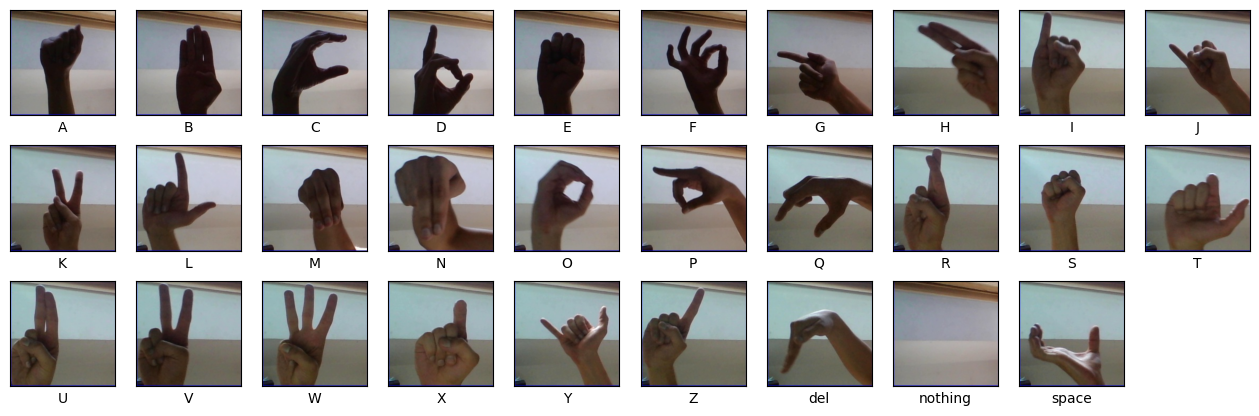

In [10]:
#Plotting all the samples
def plot_sample_images():
    figure = plt.figure()
    plt.figure(figsize=(16,5))

    for i in range (0,29):
        plt.subplot(3,10,i+1)
        plt.xticks([])
        plt.yticks([])
        path = train_dir + "/{0}/{0}1.jpg".format(alphabets[i])
        img = plt.imread(path)
        plt.imshow(img)
        plt.xlabel(alphabets[i])

plot_sample_images()

The data has a diverse dataset, it means that the dataset contains a wide range of images that cover various aspects of the objects or scenes that we want the model to recognize or understand.

## Model

### Sequentials

In [11]:
model_seq = tf.keras.models.Sequential()

model_seq.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model_seq.add(tf.keras.layers.MaxPooling2D(2, 2))
model_seq.add(tf.keras.layers.Dropout(0.2))

model_seq.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model_seq.add(tf.keras.layers.MaxPooling2D(2, 2))
model_seq.add(tf.keras.layers.Dropout(0.2)) #to minimize overfitting

model_seq.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model_seq.add(tf.keras.layers.MaxPooling2D(2, 2))
model_seq.add(tf.keras.layers.Dropout(0.2))

model_seq.add(tf.keras.layers.Flatten())
model_seq.add(tf.keras.layers.Dense(512, activation='relu'))
model_seq.add(tf.keras.layers.Dropout(0.25))
model_seq.add(tf.keras.layers.Dense(29, activation='softmax')) #because the data is a multiclass

model_seq.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 111, 111, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 54, 54, 64)        0

In [12]:
adam = Adam(clipvalue=1)
model_seq.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

history_seq = model_seq.fit(train_gen, epochs=50, steps_per_epoch = 30, validation_data = val_gen, verbose = 1, validation_steps=10)

Epoch 1/50
30/30 [==============================] - 8s 68ms/step - loss: 4.4252 - accuracy: 0.0385 - val_loss: 3.3522 - val_accuracy: 1.0000
Epoch 2/50
30/30 [==============================] - 2s 57ms/step - loss: 3.3360 - accuracy: 0.0583 - val_loss: 2.7463 - val_accuracy: 0.7156
Epoch 3/50
30/30 [==============================] - 2s 56ms/step - loss: 3.1189 - accuracy: 0.1104 - val_loss: 2.2926 - val_accuracy: 0.7781
Epoch 4/50
30/30 [==============================] - 2s 57ms/step - loss: 2.9631 - accuracy: 0.1375 - val_loss: 1.8076 - val_accuracy: 0.7344
Epoch 5/50
30/30 [==============================] - 2s 58ms/step - loss: 2.8523 - accuracy: 0.1615 - val_loss: 2.5264 - val_accuracy: 0.2562
Epoch 6/50
30/30 [==============================] - 2s 58ms/step - loss: 2.7022 - accuracy: 0.2177 - val_loss: 2.8097 - val_accuracy: 0.1531
Epoch 7/50
30/30 [==============================] - 2s 59ms/step - loss: 2.5937 - accuracy: 0.2521 - val_loss: 2.6589 - val_accuracy: 0.3406
Epoch 8/50
30

I chose to utilize Adam as the optimizer due to its simplicity compared to other optimization techniques. Adam incorporates adaptive learning rate capabilities, efficiently manages sparse gradients, and proves to be highly compatible with a diverse set of problems.

In [13]:
metrics_seq = pd.DataFrame(model_seq.history.history)
metrics_seq

,loss,accuracy,val_loss,val_accuracy
0,4.425226,0.038542,3.352203,1.000000
1,3.335962,0.058333,2.746317,0.715625
2,3.118861,0.110417,2.292592,0.778125
3,2.963059,0.137500,1.807630,0.734375
4,2.852301,0.161458,2.526382,0.256250
5,2.702185,0.217708,2.809684,0.153125
6,2.593666,0.252083,2.658930,0.340625
7,2.545246,0.247917,2.497925,0.153125
8,2.395833,0.280208,2.472229,0.243750
9,2.305257,0.320833,3.295466,0.000000


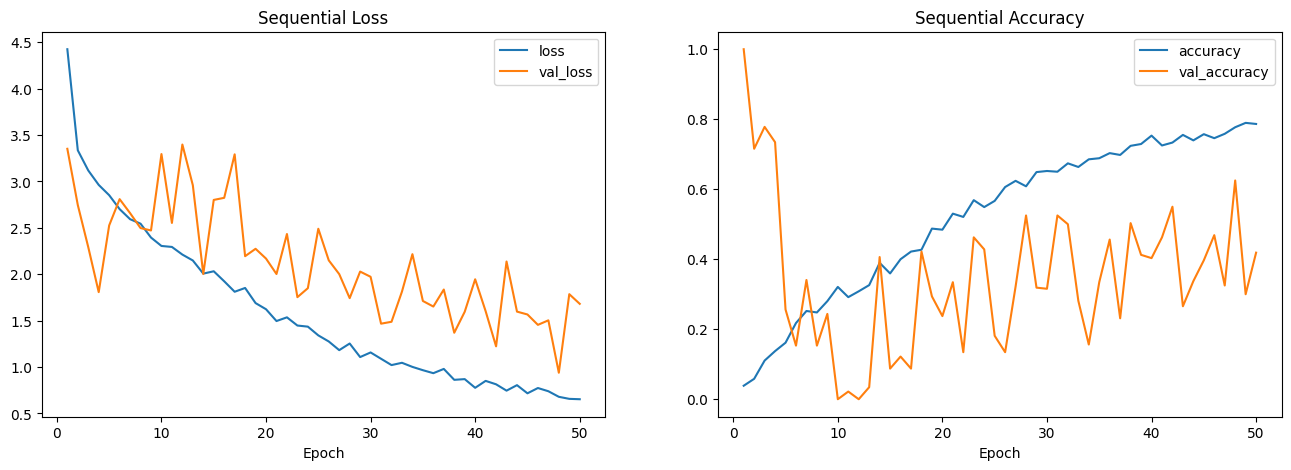

In [14]:
epoch = 50

fig, ax = plt.subplots(ncols=2, figsize=(16, 5))

# Plot loss
ax[0].plot(range(1, epoch + 1), history_seq.history['loss'], label='loss')
ax[0].plot(range(1, epoch + 1), history_seq.history['val_loss'], label='val_loss')
ax[0].set_title('Sequential Loss')
ax[0].legend()
ax[0].set_xlabel('Epoch')

# Plot accuracy
ax[1].plot(range(1, epoch + 1), history_seq.history['accuracy'], label='accuracy')
ax[1].plot(range(1, epoch + 1), history_seq.history['val_accuracy'], label='val_accuracy')
ax[1].set_title('Sequential Accuracy')
ax[1].legend()
ax[1].set_xlabel('Epoch')

plt.show()


In [15]:
#Get the final metrics on the training data
train_loss_seq, train_acc_seq = model_seq.evaluate(train_gen)
print(f'Train loss Sequential: {train_loss_seq:.4f}')
print(f'Train accuracy Sequential: {train_acc_seq:.4f}')

#Get the final metrics on the validation data
test_loss_seq, test_acc_seq = model_seq.evaluate(val_gen)
print(f'Test loss Sequential: {test_loss_seq:.4f}')
print(f'Test accuracy Sequential: {test_acc_seq:.4f}')


2175/2175 [==============================] - 84s 39ms/step - loss: 0.4067 - accuracy: 0.8744
Train loss Sequential: 0.4067
Train accuracy Sequential: 0.8744
544/544 [==============================] - 22s 40ms/step - loss: 1.9352 - accuracy: 0.4647
Test loss Sequential: 1.9352
Test accuracy Sequential: 0.4647


Based on the observation, it is evident that the training data surpasses the testing data, indicating an underfitting issue. Underfitting occurs when the model used is too simple or inadequate to capture the complexity of the data. 

In [16]:
# Generate predictions for the test data
predict_seq = model_seq.predict(val_gen)
predict_seq = np.argmax(predict_seq, axis=1)
true_label = val_gen.labels

print(classification_report(true_label,predict_seq))

544/544 [==============================] - 22s 41ms/step
              precision    recall  f1-score   support

           0       0.41      0.30      0.35       600
           1       0.44      0.72      0.54       600
           2       0.81      0.41      0.54       600
           3       0.63      0.62      0.63       600
           4       0.39      0.47      0.42       600
           5       0.92      0.85      0.88       600
           6       0.55      0.32      0.40       600
           7       0.51      0.90      0.65       600
           8       0.77      0.26      0.39       600
           9       0.80      0.53      0.64       600
          10       0.91      0.68      0.78       600
          11       0.90      0.91      0.91       600
          12       0.51      0.42      0.46       600
          13       0.31      0.23      0.27       600
          14       0.52      0.23      0.32       600
          15       0.54      0.65      0.59       600
          16       0.52 

The accuracy score from sequential model is only 46%.

In [17]:
#Try to predict
def prediction(file):
    img = tf.keras.utils.load_img(file, target_size=(224, 224,3))
    x = tf.keras.utils.img_to_array(img) / 255.0  # Normalize pixel values to [0, 1]

    plt.imshow(x)

    x = np.expand_dims(x, axis=0)

    classes = model_seq.predict(x, batch_size=1)
    idx = np.argmax(classes)
    clas = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','del','nothing','space']
    print('Prediction is a {}'.format(clas[idx]))

1/1 [==============================] - 0s 144ms/step
Prediction is a D


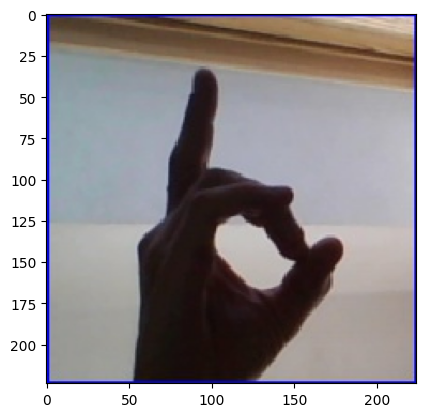

In [18]:
prediction('/content/asl_alphabet_test/asl_alphabet_test/D_test.jpg')

Despite the very low accuracy score for the sequential model, it can still successfully predict the letter 'D' and the corresponding class with accuracy.

### VGG16 (Transfer Learning)


In this approach, I will utilize the VGG16 model as a pretrained model to compare its performance with that of a manually constructed sequential model. By using a pretrained model as a starting point, we can transfer the knowledge gained from the pretraining task to a new, possibly different task. This can significantly speed up the training process and require less data for the new task.

In [19]:
#Clear session to release resources
tf.keras.backend.clear_session()

In [20]:
#Load pretrained model
inputs= [224,224,3]

vg_model = VGG16(include_top = False, weights = "imagenet" ,input_shape=inputs)
vg_model.trainable = False

In [ ]:
vg_model = Sequential([vg_model,
                         GlobalAveragePooling2D(),
                         Dense(512, activation = 'relu'),
                         BatchNormalization(), #to minimize exploding
                         Dropout(0.3),
                         Dense(1024, activation = 'relu'),
                         Dropout(0.15),
                         Dense(2048, activation = 'relu'),
                         Dropout(0.3),
                         Dense(29, activation = 'softmax') 
                         ])

In [22]:
#Model summary
vg_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1024)              5

In [23]:
adam = Adam(clipvalue=0.5)
vg_model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

historyvg = vg_model.fit(train_gen, epochs=50, steps_per_epoch = 30, validation_data = val_gen, verbose = 1, validation_steps=10)

Epoch 1/50
30/30 [==============================] - 5s 67ms/step - loss: 2.2192 - accuracy: 0.3844 - val_loss: 4.1168 - val_accuracy: 0.0000e+00
Epoch 2/50
30/30 [==============================] - 2s 58ms/step - loss: 1.0417 - accuracy: 0.6854 - val_loss: 4.1111 - val_accuracy: 0.0000e+00
Epoch 3/50
30/30 [==============================] - 2s 60ms/step - loss: 0.7606 - accuracy: 0.7646 - val_loss: 3.4504 - val_accuracy: 0.0000e+00
Epoch 4/50
30/30 [==============================] - 2s 57ms/step - loss: 0.6208 - accuracy: 0.7958 - val_loss: 4.1385 - val_accuracy: 0.0000e+00
Epoch 5/50
30/30 [==============================] - 2s 61ms/step - loss: 0.5546 - accuracy: 0.8385 - val_loss: 4.1390 - val_accuracy: 0.0000e+00
Epoch 6/50
30/30 [==============================] - 2s 58ms/step - loss: 0.5342 - accuracy: 0.8365 - val_loss: 2.9963 - val_accuracy: 0.0406
Epoch 7/50
30/30 [==============================] - 2s 57ms/step - loss: 0.4107 - accuracy: 0.8760 - val_loss: 2.5091 - val_accuracy: 

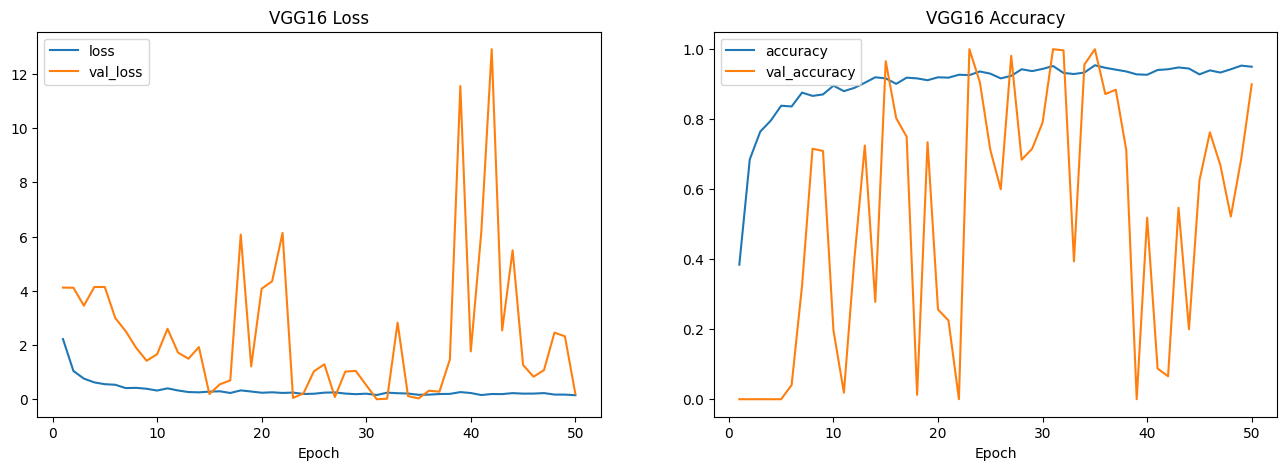

In [24]:
epoch = 50

fig, ax = plt.subplots(ncols=2, figsize=(16, 5))

# Plot loss
ax[0].plot(range(1, epoch + 1), historyvg.history['loss'], label='loss')
ax[0].plot(range(1, epoch + 1), historyvg.history['val_loss'], label='val_loss')
ax[0].set_title('VGG16 Loss')
ax[0].legend()
ax[0].set_xlabel('Epoch')

# Plot accuracy
ax[1].plot(range(1, epoch + 1), historyvg.history['accuracy'], label='accuracy')
ax[1].plot(range(1, epoch + 1), historyvg.history['val_accuracy'], label='val_accuracy')
ax[1].set_title('VGG16 Accuracy')
ax[1].legend()
ax[1].set_xlabel('Epoch')

plt.show()


In [25]:
#Get the final metrics on the training data
trainvg_loss, trainvg_acc = vg_model.evaluate(train_gen)
print(f'Train loss Sequential: {trainvg_loss:.4f}')
print(f'Train accuracy Sequential: {trainvg_acc:.4f}')

#Get the final metrics on the validation data
testvg_loss, testvg_acc = vg_model.evaluate(val_gen)
print(f'Test loss VGG16: {testvg_loss:.4f}')
print(f'Test accuracy VGG16: {testvg_acc:.4f}')


2175/2175 [==============================] - 92s 42ms/step - loss: 0.3431 - accuracy: 0.8959
Train loss Sequential: 0.3431
Train accuracy Sequential: 0.8959
544/544 [==============================] - 22s 40ms/step - loss: 1.2116 - accuracy: 0.7447
Test loss VGG16: 1.2116
Test accuracy VGG16: 0.7447


Although both models suffer from underfitting, the pretrained model achieves a much higher accuracy score, meaning it is better at making correct predictions despite not fully capturing the data's intricacies.

In [26]:
predict_vg = vg_model.predict(val_gen)
predict_vg = np.argmax(predict_vg, axis=1)
true_labelvg = val_gen.labels

print(classification_report(true_labelvg,predict_vg))

544/544 [==============================] - 21s 38ms/step
              precision    recall  f1-score   support

           0       0.71      0.86      0.78       600
           1       0.85      0.98      0.91       600
           2       0.83      0.99      0.90       600
           3       0.96      0.96      0.96       600
           4       0.93      0.57      0.70       600
           5       1.00      1.00      1.00       600
           6       1.00      0.55      0.71       600
           7       0.73      1.00      0.85       600
           8       1.00      0.58      0.73       600
           9       0.78      0.96      0.86       600
          10       1.00      0.89      0.94       600
          11       0.96      0.95      0.96       600
          12       0.52      0.83      0.64       600
          13       0.71      0.45      0.55       600
          14       0.60      0.90      0.72       600
          15       0.99      0.63      0.77       600
          16       1.00 

The accuracy score is up to 74%

In [27]:
#Try to predict
def prediction(file):
    img = tf.keras.utils.load_img(file, target_size=(224, 224))
    x = tf.keras.utils.img_to_array(img) / 255.0  # Normalize pixel values to [0, 1]

    plt.imshow(x)

    x = np.expand_dims(x, axis=0)

    classes = vg_model.predict(x, batch_size=1)
    idx = np.argmax(classes)
    clas = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','del','nothing','space']
    print('Prediction is a {}'.format(clas[idx]))

1/1 [==============================] - 0s 363ms/step
Prediction is a C


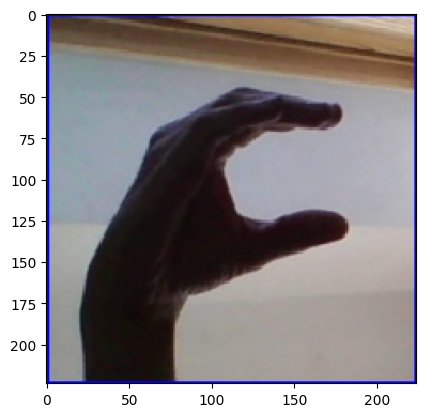

In [28]:
prediction('/content/asl_alphabet_test/asl_alphabet_test/C_test.jpg')

Despite experiencing underfitting on the training data, the model can accurately predict the images. This indicates that the model is capable of correctly recognizing the objects or classes depicted in the images with a satisfactory level of accuracy.

## Inference/Prediction

In this stage, I will conduct some inference to verify whether our model can genuinely read or make predictions successfully or not.

1/1 [==============================] - 0s 20ms/step
Prediction is a D


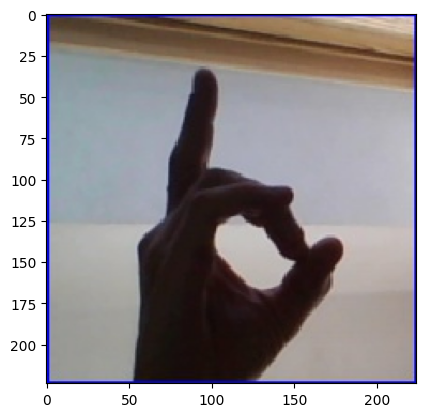

In [29]:
prediction('/content/asl_alphabet_test/asl_alphabet_test/D_test.jpg')

1/1 [==============================] - 0s 20ms/step
Prediction is a space


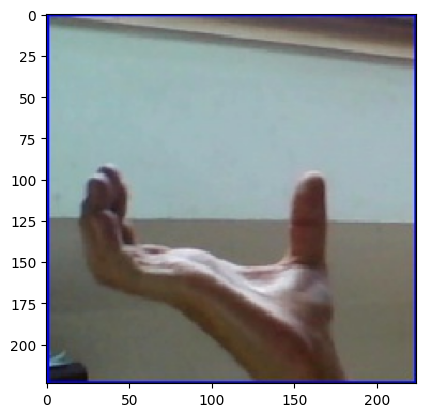

In [30]:
prediction('/content/asl_alphabet_test/asl_alphabet_test/space_test.jpg')

1/1 [==============================] - 0s 21ms/step
Prediction is a N


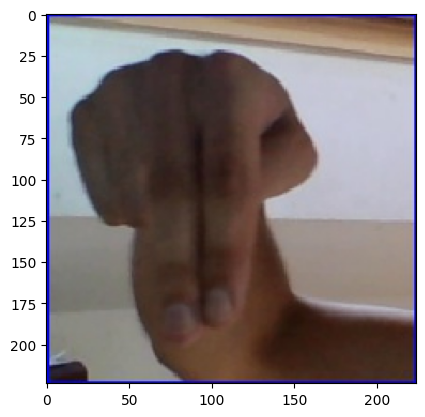

In [31]:
prediction('/content/asl_alphabet_test/asl_alphabet_test/N_test.jpg')

## Save Model

In [32]:
vg_model.trainable = False
vg_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1024)              5

In [33]:
vg_model.save('modelvgg.h5')

## Conclusion

To conclude, the model that I've developed has strengths in providing easily interpretable insights and potential transfer learning from the use of pretrained models like VGG16. Despite experiencing underfitting, the model remains efficient in predicting images. However, the underfitting weakness suggests that the model still hasn't fully grasped the complexity of the data, and its accuracy rate of 74% might be insufficient for certain applications or datasets. Addressing the existing weaknesses requires dedicated efforts to enhance the model's performance.

Some weaknesses of VGG16 include:

Having a considerably large number of parameters due to its deep architecture.
The abundance of parameters and deep layers may lead to overfitting, especially when dealing with small datasets. Similar to other traditional CNN architectures, VGG16 lacks explicit localization information, hindering precise object location identification in certain computer vision tasks.
To improve the model, I propose the following solutions. Firstly, employ transfer learning using VGG16 as the best model, comparing it with the base model. Secondly, consider data augmentation to mitigate the exploding chart and improve accuracy. Lastly, implement pre-processing techniques to prevent overfitting, underfitting, and any unwanted scenarios.


Overall, the model is still can be used to identify American Sign Language into written words.